# Experiment: Working with 4D Points


In [1]:
import math
import itertools
import random
import os

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import scipy.spatial.distance
!pip install scikit-plot
import scikitplot as skplt
import scipy.spatial.distance

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


!pip install path.py;
from path import Path

random.seed = 42

from google.colab import drive
drive.mount('/content/drive')

PATH = Path("/content/drive/My Drive/KM3Net Data/4d/")

Mounted at /content/drive


In [2]:
parent_folders = os.listdir(PATH)
folders = [dir for dir in sorted(parent_folders) if os.path.isdir(PATH/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

print("The parent folders: {0}; classes: {1}".format(parent_folders,
                                                     classes))

The parent folders: ['0', '1', 'save_0.pth', 'save_1.pth', 'save_2.pth', 'save_3.pth', 'save_4.pth', 'save_5.pth', 'save_6.pth', 'save_7.pth', 'save_8.pth', 'save_9.pth', 'save_10.pth', 'save_11.pth', 'save_12.pth', 'save_13.pth', 'save_14.pth', 'save_15.pth', 'save_16.pth', 'save_17.pth', 'save_18.pth', 'save_19.pth', 'save_20.pth', 'save_21.pth', 'save_22.pth', 'save_23.pth', 'save_24.pth', 'save_25.pth', 'save_26.pth', 'save_27.pth', 'save_28.pth', 'save_29.pth', 'save_30.pth', 'save_31.pth', 'save_32.pth', 'save_33.pth', 'save_34.pth', 'save_35.pth', 'save_36.pth', 'save_37.pth', 'save_38.pth', 'save_39.pth', 'save_40.pth', 'save_41.pth', 'save_42.pth', 'save_43.pth', 'save_44.pth', 'save_45.pth', 'save_46.pth', 'save_47.pth', 'save_48.pth', 'save_49.pth']; classes: {'0': 0, '1': 1}


# Reading `xyz` Files

In [3]:
def read_xyz(file):
    n_verts = len(file.readlines())
    file.seek(0)
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i in range(n_verts)]
    return verts

In [4]:
class PointSampler(object):
    def __call__(self, data):
        choice_indices = np.random.choice(len(data), 7168, replace=True)
        choices = [data[i] for i in choice_indices]
        
        return np.array(choices)


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        pointcloud = np.array(pointcloud)
        assert len(pointcloud.shape)==2
        return torch.from_numpy(pointcloud)

In [5]:
def default_transforms():
    return transforms.Compose([PointSampler(),
                               ToTensor()])

In [6]:
class PointCloudData(Dataset):
    """
    Reads the files in the directory and :
    1. Assigns classes
    2. Checks if it is a training or validation phase
    3. Tags files by it's class
    """
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.xyz'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pointcloud = read_xyz(file)

        if self.transforms:
            pointcloud = self.transforms((pointcloud))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [7]:
train_transforms = transforms.Compose([PointSampler(),
                    ToTensor()])

In [8]:
train_ds = PointCloudData(PATH,
                          transform=train_transforms)
valid_ds = PointCloudData(PATH,
                          valid=True,
                          folder='test',
                          transform=train_transforms)

In [9]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: '0', 1: '1'}

In [10]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  320
Valid dataset size:  80
Number of classes:  2
Sample pointcloud shape:  torch.Size([7168, 4])
Class:  0


In [11]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

# Model

In [12]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=4):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.AvgPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=4)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(4,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.AvgPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsigmoid(output), matrix3x3, matrix64x64

In [13]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(4, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

# Train

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=16, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1

In [16]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [17]:
def train(model, train_loader, val_loader=None,  epochs=50, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % 
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        checkpoint = PATH/ 'save_' + str(epoch) + '.pth'

        if save:
          torch.save(pointnet.state_dict(), checkpoint)
          print('Model saved to ', checkpoint)

In [23]:
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /   10], loss: 0.569
Valid accuracy: 50 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_0.pth
[Epoch: 2, Batch:   10 /   10], loss: 0.242
Valid accuracy: 51 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_1.pth
[Epoch: 3, Batch:   10 /   10], loss: 0.121
Valid accuracy: 48 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_2.pth
[Epoch: 4, Batch:   10 /   10], loss: 0.067
Valid accuracy: 51 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_3.pth
[Epoch: 5, Batch:   10 /   10], loss: 0.045
Valid accuracy: 56 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_4.pth
[Epoch: 6, Batch:   10 /   10], loss: 0.031
Valid accuracy: 56 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_5.pth
[Epoch: 7, Batch:   10 /   10], loss: 0.025
Valid accuracy: 56 %
Model saved to  /content/drive/My Drive/KM3Net Data/4d/save_6.pth
[Epoch: 8, Batch:   10 /   10], loss: 0.020
Valid accuracy: 52 %
Model saved to  /c

# Test

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load(PATH/'save_37.pth'))
pointnet.eval();

In [20]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /    2]
Batch [   2 /    2]


In [21]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[15, 25],
       [ 9, 31]])

In [23]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


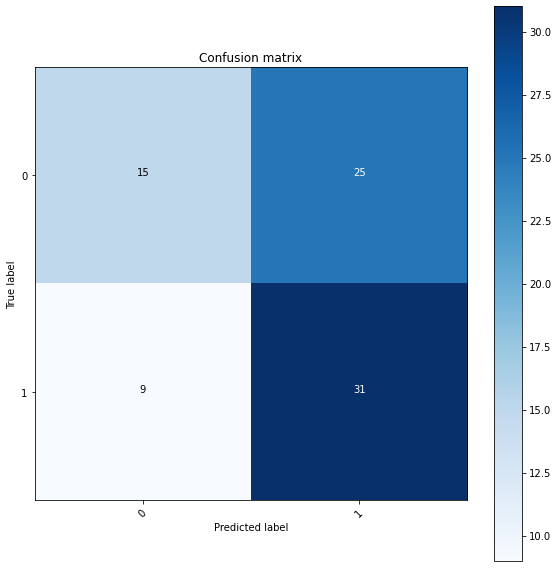

In [25]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./best.jpg", dpi=600, bbox_inches = "tight")

Classification report for Pointnet:

               precision    recall  f1-score   support

           0       0.62      0.38      0.47        40
           1       0.55      0.78      0.65        40

    accuracy                           0.57        80
   macro avg       0.59      0.57      0.56        80
weighted avg       0.59      0.57      0.56        80

FPR [0.    0.625 1.   ] 
 TPR: [0.    0.775 1.   ] 
 THRESHOLDS: [2 1 0] 



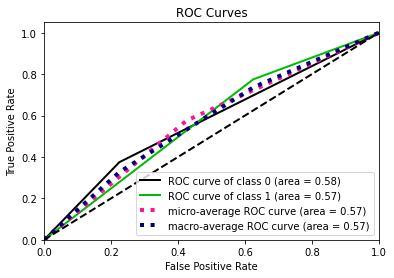

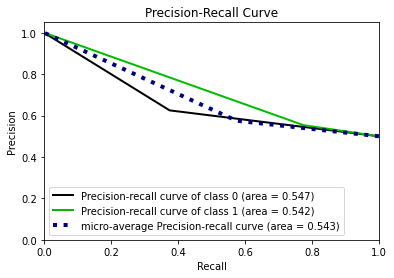

In [26]:
print("Classification report for Pointnet:\n\n {}".format(classification_report(all_labels,
                                                                            all_preds,
                                                                            target_names=list(classes.keys()))))

roc_auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_preds)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

proba = [1 - x for x in all_preds] 
len(all_preds)
skplt.metrics.plot_roc(all_labels, np.column_stack([proba, all_preds]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")
plt.show()

skplt.metrics.plot_precision_recall(all_labels,
                                    np.column_stack([proba, all_preds]))
plt.savefig("./west.jpg", dpi=600, bbox_inches = "tight")
plt.show()